In [1]:

# Pytorch - for build and train network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# for the classifiers also the cluster.
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# for the classification evaluation.
from sklearn import metrics
from sklearn.metrics import f1_score

# handel the imbalanced dataset us  SMOTE method
from imblearn.over_sampling import SMOTE
from collections import Counter

from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from tqdm.notebook import tqdm

import pickle
import math

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import re

import os

In [2]:
# get the path of the folder.

cwd = os.getcwd()
cwd = cwd 
cwd

'/Users/kai/Library/CloudStorage/OneDrive-HochschuleLuzern/HSLU/00_Thesis/kai_2024/notebook'

In [3]:
df = pd.read_excel(cwd+"/tamedia 1000 transcripts to label 2024-06-08.xlsx", index_col=0)
# df.head()
# df.tail()
# df.shape

### Clean data

In [4]:
# Define a function to split, expand motive types, and remove probabilities
def split_and_expand_motive_types(row):
    text = str(row['motive_final'])  # Ensure motive_final is treated as a string
    if text == 'Keine' or text.lower() == 'nan':
        return [row]  # Return the row unchanged if the text is exactly '0' or 'NaN'

    matches = re.findall(r'(\w+)\s*\(\d*\.?\d*\)', text)  # Extract just the motive name, ignoring the probability
    if matches:
        # Generate a new row for each motive type without the probability
        expanded_rows = []
        for match in matches:
            new_row = row.copy()
            new_row['motive_final'] = match  # Set the motive name without the probability
            expanded_rows.append(new_row)
        return expanded_rows
    else:
        return [row]  # Return the original row if no matches found

# Apply the function and expand the DataFrame
expanded_df = pd.DataFrame([expanded_row for index, row in df.iterrows() for expanded_row in split_and_expand_motive_types(row)])

# Display the resulting DataFrame
print(expanded_df.shape)
expanded_df.head()

(1079, 2)


,motive_final,textAno4
1,Ratsuche,"SPEAKER_A : Ich glaube , bei der Berner Zeitun..."
1,Vertrauen,"SPEAKER_A : Ich glaube , bei der Berner Zeitun..."
2,Keine,"SPEAKER_B : Berner Zeitung , Aboservice , {nam..."
3,Preisoptimierung,SPEAKER_A : Finanz und Wirtschaft . Mein Name ...
4,Vertrauen,"SPEAKER_A : Schweizer Familie , Aboservice , {..."


In [5]:
df = expanded_df
# Display the resulting DataFrame
print(df.shape)
print (df['motive_final'].unique())
df.head()

(1079, 2)
['Ratsuche' 'Vertrauen' 'Keine' 'Preisoptimierung' 'Abgabe' 'Pragmatismus'
 'Selbermachen' 'Vermeidung' '0.5 Selbermachen, 0.5 Keine' 'Keine '
 'Abgabe  ' 'Preisoptimierer' 'Selbermachen 0.5, Ratsuche 0.5' nan]


,motive_final,textAno4
1,Ratsuche,"SPEAKER_A : Ich glaube , bei der Berner Zeitun..."
1,Vertrauen,"SPEAKER_A : Ich glaube , bei der Berner Zeitun..."
2,Keine,"SPEAKER_B : Berner Zeitung , Aboservice , {nam..."
3,Preisoptimierung,SPEAKER_A : Finanz und Wirtschaft . Mein Name ...
4,Vertrauen,"SPEAKER_A : Schweizer Familie , Aboservice , {..."


In [6]:
df = df[['motive_final', 'textAno4']]
df['motive_final'] = df['motive_final'].fillna('0')
df['motive_final'] = df['motive_final'].replace('Keine ', 'Keine')
df['motive_final'] = df['motive_final'].replace('Abgabe  ', 'Abgabe')
df['motive_final'] = df['motive_final'].replace('Preisoptimierer', 'Preisoptimierung')

print (df['motive_final'].unique())

['Ratsuche' 'Vertrauen' 'Keine' 'Preisoptimierung' 'Abgabe' 'Pragmatismus'
 'Selbermachen' 'Vermeidung' '0.5 Selbermachen, 0.5 Keine'
 'Selbermachen 0.5, Ratsuche 0.5' '0']


In [7]:
# Define a function to split, expand motive types, and handle specific cases
def split_and_expand_motive_types2(row):
    text = str(row['motive_final'])  # Ensure motive_final is treated as a string
    if text == '0' or text.lower() == 'nan':
        return [row]  # Return the row unchanged if the text is exactly '0' or 'NaN'

    expanded_rows = []

    # Handle the specific case "Selbermachen 0.5, Ratsuche 0.5"
    if text == 'Selbermachen 0.5, Ratsuche 0.5':
        motives = ['Selbermachen', 'Ratsuche']
    # Handle the specific case "0.5 Selbermachen, 0.5 n/a"
    elif text == '0.5 Selbermachen, 0.5 Keine':
        motives = ['Selbermachen', 'Keine']
    else:
        # Generic handling: Extract motive names without probabilities
        motives = re.findall(r'(\w+)\s*\d*\.?\d*', text)

    # Generate a new row for each motive name without the probability
    for motive in motives:
        new_row = row.copy()
        new_row['motive_final'] = motive  # Set the motive name without the probability
        expanded_rows.append(new_row)

    return expanded_rows

# Apply the function and expand the DataFrame
expanded_df = pd.DataFrame([expanded_row for index, row in df.iterrows() for expanded_row in split_and_expand_motive_types2(row)])

# Display the resulting DataFrame
print(expanded_df.shape)
expanded_df.head()

(1081, 2)


,motive_final,textAno4
1,Ratsuche,"SPEAKER_A : Ich glaube , bei der Berner Zeitun..."
1,Vertrauen,"SPEAKER_A : Ich glaube , bei der Berner Zeitun..."
2,Keine,"SPEAKER_B : Berner Zeitung , Aboservice , {nam..."
3,Preisoptimierung,SPEAKER_A : Finanz und Wirtschaft . Mein Name ...
4,Vertrauen,"SPEAKER_A : Schweizer Familie , Aboservice , {..."


In [8]:
df = expanded_df

# Display the resulting DataFrame
print(df.shape)
print (df['motive_final'].unique())
df.head()

(1081, 2)
['Ratsuche' 'Vertrauen' 'Keine' 'Preisoptimierung' 'Abgabe' 'Pragmatismus'
 'Selbermachen' 'Vermeidung' '0']


,motive_final,textAno4
1,Ratsuche,"SPEAKER_A : Ich glaube , bei der Berner Zeitun..."
1,Vertrauen,"SPEAKER_A : Ich glaube , bei der Berner Zeitun..."
2,Keine,"SPEAKER_B : Berner Zeitung , Aboservice , {nam..."
3,Preisoptimierung,SPEAKER_A : Finanz und Wirtschaft . Mein Name ...
4,Vertrauen,"SPEAKER_A : Schweizer Familie , Aboservice , {..."


In [9]:
# Replace '\n' with ' ' in the 'textAno4' column
df['textAno4'] = df['textAno4'].str.replace('\n', ' ')

In [10]:
# Extract unique placeholders
unique_placeholders = set(re.findall(r'\{([^}]+)\}', ' '.join(df['textAno4'])))
print(unique_placeholders)

# Extract unique speaker identifiers
unique_speakers = set(re.findall(r'([A-Z_]+)\s*:', ' '.join(df['textAno4'])))
print(unique_speakers)

{' e-mail ', ' number ', ' town ', ' street { street name ', ' street name ', ' address ', 'name', ' { e-mail '}
{'SPEAKER_A', 'SPEAKER_D', 'SPEAKER_C', 'SPEAKER_UNKNOWN', 'SPEAKER_B'}


In [11]:
translations = {}

# Translate each placeholder
translations[' street { street name '] = 'Strassenname'
translations[' street name '] = 'Strassenname'
translations[' number '] = 'Nummer'
translations[' address '] = 'Adresse'
translations[' { e-mail '] = 'E-Mail'
translations[' e-mail '] = 'E-Mail'
translations['name'] = 'Name'
translations[' town '] = 'Stadt'

# Translate each speaker
translations['SPEAKER_A'] = 'SPRECHER_A'
translations['SPEAKER_B'] = 'SPRECHER_B'
translations['SPEAKER_C'] = 'SPRECHER_C'
translations['SPEAKER_D'] = 'SPRECHER_D'
translations['SPEAKER_UNKNOWN'] = 'SPRECHER_UNBEKANNT'

# Replace placeholders in DataFrame
for eng_placeholder, ger_translation in translations.items():
    df['textAno4'] = df['textAno4'].str.replace(eng_placeholder, ger_translation)

# Replace speakers in DataFrame
for eng_speaker, ger_speaker in translations.items():
    df['textAno4'] = df['textAno4'].str.replace(eng_speaker, ger_speaker)

print (set(re.findall(r'\{([^}]+)\}', ' '.join(df['textAno4']))))
print (set(re.findall(r'([A-Z_]+)\s*:', ' '.join(df['textAno4']))))
df.head()

{'StrassenName', 'E-Mail', 'Adresse', 'Nummer', 'Name', 'Stadt'}
{'SPRECHER_C', 'SPRECHER_D', 'SPRECHER_UNBEKANNT', 'SPRECHER_A', 'SPRECHER_B'}


,motive_final,textAno4
1,Ratsuche,"SPRECHER_A : Ich glaube , bei der Berner Zeitu..."
1,Vertrauen,"SPRECHER_A : Ich glaube , bei der Berner Zeitu..."
2,Keine,"SPRECHER_B : Berner Zeitung , Aboservice , {Na..."
3,Preisoptimierung,SPRECHER_A : Finanz und Wirtschaft . Mein Name...
4,Vertrauen,"SPRECHER_A : Schweizer Familie , Aboservice , ..."


In [12]:
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

# Function to count tokens in a text
def count_tokens(text):
    tokens = word_tokenize(text)  # Tokenize text using NLTK's word_tokenize
    return len(tokens)

# Apply count_tokens function to 'text' column and find maximum
print (df['textAno4'].apply(count_tokens).min())
print (df['textAno4'].apply(count_tokens).max())

[nltk_data] Downloading package punkt_tab to /Users/kai/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


39
4519


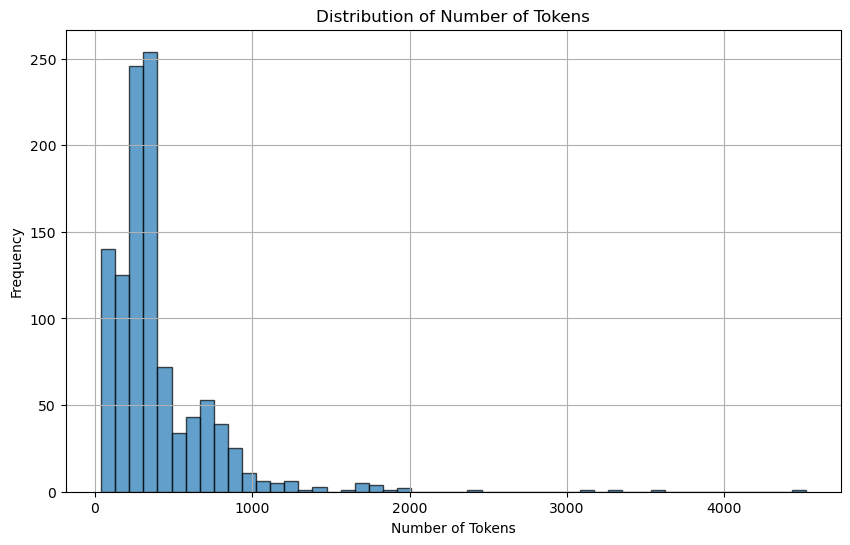

In [13]:
# Plot distribution of number of tokens
plt.figure(figsize=(10, 6))
plt.hist(df['textAno4'].apply(count_tokens), bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Number of Tokens')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [14]:
df.head()

,motive_final,textAno4
1,Ratsuche,"SPRECHER_A : Ich glaube , bei der Berner Zeitu..."
1,Vertrauen,"SPRECHER_A : Ich glaube , bei der Berner Zeitu..."
2,Keine,"SPRECHER_B : Berner Zeitung , Aboservice , {Na..."
3,Preisoptimierung,SPRECHER_A : Finanz und Wirtschaft . Mein Name...
4,Vertrauen,"SPRECHER_A : Schweizer Familie , Aboservice , ..."


In [15]:
# df['label'] = -1
# # # 'Ratsuche' 'Vertrauen' 'Keine' 'Preisoptimierung' 'Abgabe' 'Pragmatismus' 'Selbermachen' 'Vermeidung'
# for i in tqdm(range(df.shape[0])):
#   if df.iloc[i, 0] == 'Keine':
#     df.iloc[i, -1] = 1
#   elif df.iloc[i, 0] == 'Ratsuche':
#     df.iloc[i, -1] = 2
#   elif df.iloc[i, 0] == 'Preisoptimierung':
#     df.iloc[i, -1] = 3
#   elif df.iloc[i, 0] == 'Vertrauen':
#     df.iloc[i, -1] = 4
#   elif df.iloc[i, 0] == 'Pragmatismus':
#     df.iloc[i, -1] = 5
#   elif df.iloc[i, 0] == 'Selbermachen':
#     df.iloc[i, -1] = 6
#   elif df.iloc[i, 0] == 'Abgabe':
#     df.iloc[i, -1] = 7
#   elif df.iloc[i, 0] == 'Vermeidung':
#     df.iloc[i, -1] = 8

df.rename(columns={'textAno4': 'text','motive_final':'label'}, inplace = True)
# df['title'] = ''
# Get unique labels
unique_labels = df['label'].unique()

# Create a label encoder
label_encoder = {label: i for i, label in enumerate(unique_labels)}

# Encode the labels
df['label_encoded'] = df['label'].map(label_encoder)

# print(df)
# df['label'].fillna(-1, inplace=True)
# # df = df[['motive_final', 'text']]
df.head()

,label,text,label_encoded
1,Ratsuche,"SPRECHER_A : Ich glaube , bei der Berner Zeitu...",0
1,Vertrauen,"SPRECHER_A : Ich glaube , bei der Berner Zeitu...",1
2,Keine,"SPRECHER_B : Berner Zeitung , Aboservice , {Na...",2
3,Preisoptimierung,SPRECHER_A : Finanz und Wirtschaft . Mein Name...,3
4,Vertrauen,"SPRECHER_A : Schweizer Familie , Aboservice , ...",1


In [16]:
df.label.unique()
# df.head()

array(['Ratsuche', 'Vertrauen', 'Keine', 'Preisoptimierung', 'Abgabe',
       'Pragmatismus', 'Selbermachen', 'Vermeidung', '0'], dtype=object)

In [17]:
df.label_encoded.unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [18]:
df[df['label'] != '0'].shape,  df[df['label'] == '0'].shape ,df[df['label_encoded'] != 8].shape,  df[df['label_encoded'] == 8].shape

((416, 3), (665, 3), (416, 3), (665, 3))

### Train and test dataset

In [19]:
# Select the text with valid labeled motive type
condition = (df['label'] != '0')

# Filter the DataFrame based on the condition
df1 = df[condition]
print (df1.shape)
df1['label'].unique()

(416, 3)


array(['Ratsuche', 'Vertrauen', 'Keine', 'Preisoptimierung', 'Abgabe',
       'Pragmatismus', 'Selbermachen', 'Vermeidung'], dtype=object)

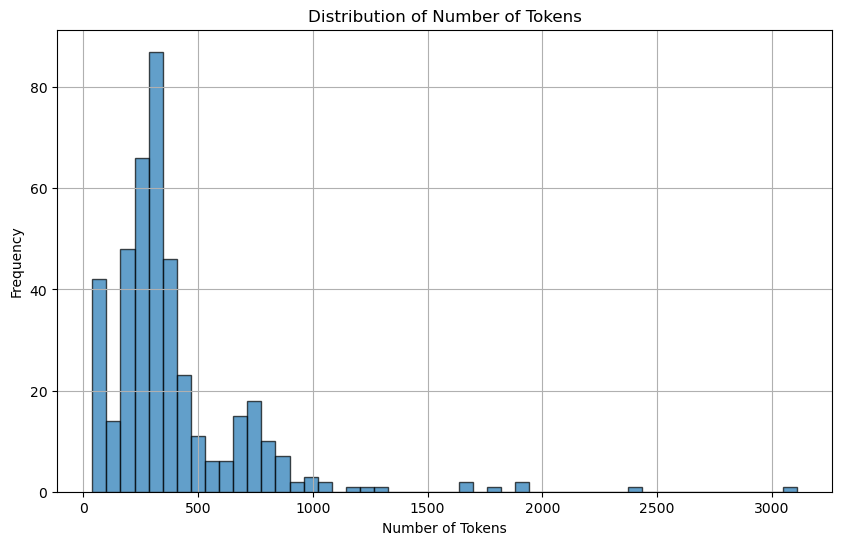

In [20]:
# Plot distribution of number of tokens
plt.figure(figsize=(10, 6))
plt.hist(df1['text'].apply(count_tokens), bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Number of Tokens')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

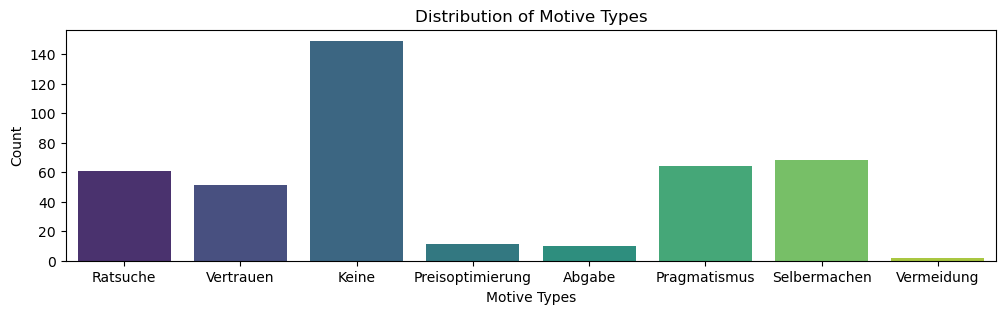

In [21]:
plt.figure(figsize=(12, 3))
sns.countplot(x='label', data=df1, palette='viridis')
plt.title('Distribution of Motive Types')
plt.xlabel('Motive Types')
plt.ylabel('Count')
plt.show()

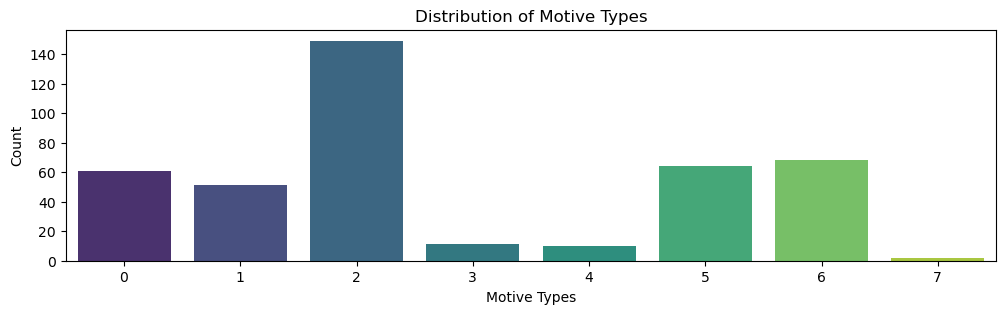

In [22]:
plt.figure(figsize=(12, 3))
sns.countplot(x='label_encoded', data=df1, palette='viridis')
plt.title('Distribution of Motive Types')
plt.xlabel('Motive Types')
plt.ylabel('Count')
plt.show()

In [23]:
binary_df = df1.copy()
for i in df['label_encoded'].unique():
    binary_df[f'label_{i}'] = binary_df['label_encoded'].apply(lambda x: 1 if x == i else 0)

binary_df.head()

,label,text,label_encoded,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7,label_8
1,Ratsuche,"SPRECHER_A : Ich glaube , bei der Berner Zeitu...",0,1,0,0,0,0,0,0,0,0
1,Vertrauen,"SPRECHER_A : Ich glaube , bei der Berner Zeitu...",1,0,1,0,0,0,0,0,0,0
2,Keine,"SPRECHER_B : Berner Zeitung , Aboservice , {Na...",2,0,0,1,0,0,0,0,0,0
3,Preisoptimierung,SPRECHER_A : Finanz und Wirtschaft . Mein Name...,3,0,0,0,1,0,0,0,0,0
4,Vertrauen,"SPRECHER_A : Schweizer Familie , Aboservice , ...",1,0,1,0,0,0,0,0,0,0


### Test dataset

In [24]:
# Filter the DataFrame for test dataset
df2 = df[df['label'] == '0']
print (df2.shape)
# df2.head()

(665, 3)


## Vectorize - TFIDF


In [25]:
# vectorize
# true_k = len(binary_df.label.unique())
binary_label = [f'label_{i}' for i in df1['label_encoded'].unique()]
X_l = binary_df.text
y_l = binary_df[binary_label]
X_ul = df2.text
# y_l

In [26]:


vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words=None,
)
t0 = time()
X_l_tfidf = vectorizer.fit_transform(X_l)
X_ul_tfidf = vectorizer.fit_transform(X_ul)

# print(f"vectorization done in {time() - t0:.3f} s")
# print(f"n_samples: {X_l_tfidf.shape[0]}, n_features: {X_l_tfidf.shape[1]}")

In [27]:

lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
t0 = time()
X_l_lsa = lsa.fit_transform(X_l_tfidf)
X_ul_lsa = lsa.fit_transform(X_ul_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

LSA done in 0.201 s
Explained variance of the SVD step: 50.7%


In [28]:
for i in range(8):
    print(Counter(y_l[f'label_{i}']))

Counter({0: 355, 1: 61})
Counter({0: 365, 1: 51})
Counter({0: 267, 1: 149})
Counter({0: 405, 1: 11})
Counter({0: 406, 1: 10})
Counter({0: 352, 1: 64})
Counter({0: 348, 1: 68})
Counter({0: 414, 1: 2})


## Top terms per cluster
Since TfidfVectorizer can be inverted we can identify the cluster centers, which provide an intuition of the most influential words for each cluster. See the example script Classification of text documents using sparse features for a comparison with the most predictive words for each target class.

# Data prepare for RLCO

In [29]:
X_ul = X_ul_lsa
env_input = []

for i in range(7):

    # split the training(labeled) as 50% of  labeled dataset
    X_l_train, X_l_test, y_l_train, y_l_test = train_test_split(X_l_lsa, y_l[f'label_{i}'], test_size=0.5, random_state=4)
    # SMOTE rebanlance the label
    if sum(y_l_train) < 5:
        sm = SMOTE(random_state=42, k_neighbors=sum(y_l_train)-1)
    else:
        sm = SMOTE(random_state=42)
    X_l_train, y_l_train = sm.fit_resample(X_l_train, y_l_train)
    env_input.append([ X_l_train, X_l_test, y_l_train, y_l_test])



In [30]:

# Initialize classifiers (KNN and SVM)
knn = KNeighborsClassifier(n_neighbors=10, metric='cosine')
svm = SVC(kernel='rbf', probability=True, tol=1e-4, max_iter=10000, C=1.0)
classifiers = [knn, svm]

In [31]:
# define ENV

# for clustering the unlabeld data



class Env():
    def __init__(self, classifiers, input_ul_data, k, X_test, y_test, X_reset, y_reset):
        # super().__init__
        self.models = classifiers
    
        # UN LABEL DATA
        self.X_ul = input_ul_data
        # define the evaluate data, later use for the reward
        self.X_eval = X_test
        self.y_eval = y_test
        self.X_reset = X_reset
        self.y_reset = y_reset
        # cluster the data
        self.action_size = k
        self.kmeans = KMeans(n_clusters=k,  n_init=10)
        self.cluster_label = self.kmeans.fit_predict(self.X_ul)
        self.u_cluster_label = np.unique(self.cluster_label)
        self.centroids = self.kmeans.cluster_centers_
        self.observation_size = self.get_state(reset=True).shape[1]
        self.prev_macro_f1 = 0.0

    # update 2 clf
    def train_2_clf(self, X, y):
        self.models[0].fit(X, y)
        self.models[1].fit(X, y)

    def get_state(self, reset=False):
        """
        Generate a state representation by predicting probabilities on centroids using stored models.
        Optionally resets and retrains models using X_reset and y_reset.

        :param reset: Boolean flag to reset and retrain models before prediction.
        :return: Torch tensor of concatenated probabilities reshaped as (1, -1).
        """
        if reset:
            if self.X_reset is not None and self.y_reset is not None:
                self.train_2_clf(self.X_reset, self.y_reset)
            else:
                raise ValueError("Reset datasets X_reset or y_reset are not provided.")
        
        if not hasattr(self, 'models') or len(self.models) < 2:
            raise ValueError("Model list is incomplete or not set.")

        try:
            out_1 = self.models[0].predict_proba(self.centroids)
            out_2 = self.models[1].predict_proba(self.centroids)
        except Exception as e:
            raise RuntimeError("Model prediction failed: " + str(e))
        
        state_proba = np.concatenate((out_1, out_2), axis=1)
        return torch.from_numpy(state_proba).to(torch.float32).reshape(1, -1)


    def get_f1(self):
        classifier_weights = [clf.score(self.X_eval, self.y_eval) for clf in [self.models[0], self.models[1]]]  # Weights based on validation accuracy
        combined_probabilities = np.average(
            [clf.predict_proba(self.X_eval) for clf in [self.models[0], self.models[1]]],
            axis=0,
            weights=classifier_weights
        )

        # Get final predictions from combined probabilities
        combined_predictions = np.argmax(combined_probabilities, axis=1)


        # Calculate F1 scores per class (harmonic means)
        f1_macro = f1_score(self.y_eval, combined_predictions, average='macro')
        f1_micro = f1_score(self.y_eval, combined_predictions, average='micro')

        # Compute Macro-F1 as arithmetic mean of F1 scores
        macro_f1 = np.mean(f1_macro)
        micro_f1 = np.mean(f1_micro)
        return macro_f1, micro_f1

    ######
    ######
    def get_subset(self, action):
        # choose subset
        subset = self.X_ul[self.cluster_label == action]
        return subset

    def co_training(self, subset):

        # Average class probabilities across classifiers
        avg_probabilities = np.mean([clf.predict_proba(subset) for clf in self.models], axis=0)

        # Assign the label with the highest average probability
        y_ul_action = np.argmax(avg_probabilities, axis=1)
        # print(y_ul_action)

        ########### update the label_set for traning
        X_updated = np.concatenate((X_l_train, subset), axis=0)
        y_updated = np.concatenate((y_l_train, y_ul_action), axis=0)

        # print(f'X shape is {X_updated.shape} \ny shape is {y_updated.shape}')

        ############# use the updated labeld dateset retrain those 2 classifier
        self.train_2_clf(X_updated, y_updated)

       
        return self.get_f1()

    def step(self, action):
        # GET THE bigining state accuracy, later use to calculate the reward
        macrof1, microf1 = self.get_f1()

        # choose subset
        choosen_subset =  self.get_subset(action)


        # cotraining the 2 classifier
        new_marco_f1, new_micro_f1 = self.co_training(choosen_subset)

        # get the next state_
        n_state = self.get_state()

        ##############
        # calculate the reward
        ##############
        if new_marco_f1 > macrof1:
            reward_0 = new_marco_f1 - macrof1
        else:
            reward_0 = 0

        return n_state, reward_0, new_marco_f1, new_micro_f1


In [32]:
k = 20
envs = []
for i in range(7):
    envs.append(Env(classifiers, input_ul_data=X_ul, k=k, X_test=env_input[i][1], y_test=env_input[i][3], X_reset=env_input[i][0], y_reset=env_input[i][2]))

# env = Env(classifiers, input_ul_data=X_ul, k=k, X_test=X_l_test, y_test=y_l_test, X_reset=X_l_train, y_reset=y_l_train)
#    env_input.append([ X_l_train, X_l_test, y_l_train, y_l_test])

In [33]:
# Actor-Critic Network
class ActorCritic(nn.Module):
    def __init__(self, state_size, action_size):
        super(ActorCritic, self).__init__()
        # Shared layers
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)

        # Actor: outputs action probabilities (softmax)
        self.actor = nn.Linear(128, action_size)


        # Critic: outputs state value (for advantage calculation)
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        # Policy (actor): softmax over actions
        action_probs = torch.softmax(self.actor(x), dim=-1)

        # Value (critic): state value estimation
        state_value = self.critic(x)

        return action_probs, state_value

In [34]:
# Assuming the ActorCritic class and environment 'env' are properly defined
# Create an instance of the ActorCritic network
actor_critic_networks = []
optimizers = []
for i in range(7):
    actor_critic_networks.append(ActorCritic(envs[i].observation_size, envs[i].action_size))
    # actor_critic = ActorCritic(env.observation_size, env.action_size)
    optimizers.append(optim.Adam(actor_critic_networks[i].parameters(), lr=0.001))

# Training parameters
num_episodes = 200
gamma = 0.99
results = []

In [35]:
for i in range(7):
    # Training parameters
    #track scores
    episode_rewards = []
    episode_f1s = []
    macro_f1_scores = []
    micro_f1_scores = []
    # Main training loop
    for episode in tqdm(range(num_episodes)):
        state = envs[i].get_state(reset=True)
        # state = torch.FloatTensor(state).unsqueeze(0)  # Shape adjustment for single sample
        episode_reward = 0

        for t in range(1, 200):  # Limit the number of time steps
            # No need to use GradientTape; PyTorch handles gradients automatically
            # Choose an action using the actor
            action_probs, state_value = actor_critic_networks[i](state)
            dist = torch.distributions.Categorical(action_probs)
            action = dist.sample()


            # Take the chosen action and observe the next state and reward
            next_state, reward, macro_f1, micro_f1 = envs[i].step(action.item())
            next_state = torch.FloatTensor(next_state).unsqueeze(0)

            # Compute the advantage
            # _, state_value = actor_critic(state)
            _, next_state_value = actor_critic_networks[i](next_state)
            advantage = reward + gamma * next_state_value - state_value

            # Compute actor and critic losses
            actor_loss = -dist.log_prob(action) * advantage.detach()
            critic_loss = advantage.pow(2)

            # Combine losses for joint update
            total_loss = actor_loss + critic_loss

            # Update actor and critic
            optimizers[i].zero_grad()
            total_loss.backward()
            optimizers[i].step()

            state = next_state
            episode_reward += reward
            episode_f1s.append(macro_f1)
            if episode == num_episodes - 1:
                macro_f1_scores.append(macro_f1)
                micro_f1_scores.append(micro_f1)

        episode_rewards.append(episode_reward)

        if episode % 10 == 0:
            print(f"CLASS_{i} Episode {episode}, Reward: {episode_reward}")
    results.append([episode_rewards, episode_f1s, macro_f1_scores, micro_f1_scores])

  0%|          | 0/200 [00:00<?, ?it/s]

CLASS_0 Episode 0, Reward: 0.9724504306990653
CLASS_0 Episode 10, Reward: 0.9898778722173418
CLASS_0 Episode 20, Reward: 1.1722037007903294
CLASS_0 Episode 30, Reward: 1.4024454373920818
CLASS_0 Episode 40, Reward: 1.885379971030562
CLASS_0 Episode 50, Reward: 1.8980426883044952
CLASS_0 Episode 60, Reward: 1.7409695571538895
CLASS_0 Episode 70, Reward: 0.2200478803093155
CLASS_0 Episode 80, Reward: 0.2381518738667267
CLASS_0 Episode 90, Reward: 0.22861371641827127
CLASS_0 Episode 100, Reward: 0.2346488640351579
CLASS_0 Episode 110, Reward: 0.2310899314162143
CLASS_0 Episode 120, Reward: 1.8958962724992021
CLASS_0 Episode 130, Reward: 2.071299050998713
CLASS_0 Episode 140, Reward: 1.9202589896841311
CLASS_0 Episode 150, Reward: 2.024367747928298
CLASS_0 Episode 160, Reward: 1.9288191166452828
CLASS_0 Episode 170, Reward: 1.9636548550313853
CLASS_0 Episode 180, Reward: 1.7393737206102962
CLASS_0 Episode 190, Reward: 1.8847257916377274


  0%|          | 0/200 [00:00<?, ?it/s]

CLASS_1 Episode 0, Reward: 0.8324783206960027
CLASS_1 Episode 10, Reward: 1.3561606300715536
CLASS_1 Episode 20, Reward: 1.3441465272954127
CLASS_1 Episode 30, Reward: 1.844998832579332
CLASS_1 Episode 40, Reward: 2.2424325133360434
CLASS_1 Episode 50, Reward: 2.684507397254858
CLASS_1 Episode 60, Reward: 2.1056267931144026
CLASS_1 Episode 70, Reward: 2.0184535561330668
CLASS_1 Episode 80, Reward: 2.1373086363787457
CLASS_1 Episode 90, Reward: 2.1226892094869676
CLASS_1 Episode 100, Reward: 1.5414805331947288
CLASS_1 Episode 110, Reward: 2.725859067737609
CLASS_1 Episode 120, Reward: 2.1623197450125446
CLASS_1 Episode 130, Reward: 2.6914397184165977
CLASS_1 Episode 140, Reward: 2.692355384858984
CLASS_1 Episode 150, Reward: 2.768520902093234
CLASS_1 Episode 160, Reward: 2.080254377276764
CLASS_1 Episode 170, Reward: 1.685646700734016
CLASS_1 Episode 180, Reward: 2.061482218576133
CLASS_1 Episode 190, Reward: 2.5302187123513917


  0%|          | 0/200 [00:00<?, ?it/s]

CLASS_2 Episode 0, Reward: 0.7356590492240749
CLASS_2 Episode 10, Reward: 1.13007853323487
CLASS_2 Episode 20, Reward: 1.7686714178049128
CLASS_2 Episode 30, Reward: 1.7348412338447403
CLASS_2 Episode 40, Reward: 1.805124322893371
CLASS_2 Episode 50, Reward: 1.7347582587352333
CLASS_2 Episode 60, Reward: 1.7435429026603104
CLASS_2 Episode 70, Reward: 1.873147485991311
CLASS_2 Episode 80, Reward: 1.7980646522379062
CLASS_2 Episode 90, Reward: 1.8906352556529262
CLASS_2 Episode 100, Reward: 1.818699724799485
CLASS_2 Episode 110, Reward: 1.7776842650454316
CLASS_2 Episode 120, Reward: 1.7817026055689098
CLASS_2 Episode 130, Reward: 0.08395475842273153
CLASS_2 Episode 140, Reward: 1.8150866772682925
CLASS_2 Episode 150, Reward: 1.7843324627242672
CLASS_2 Episode 160, Reward: 1.7483967844378459
CLASS_2 Episode 170, Reward: 1.7693494729359287
CLASS_2 Episode 180, Reward: 1.878269569381051
CLASS_2 Episode 190, Reward: 1.7288579816620657


  0%|          | 0/200 [00:00<?, ?it/s]

CLASS_3 Episode 0, Reward: 0.7110678366760461
CLASS_3 Episode 10, Reward: 1.247649481672708
CLASS_3 Episode 20, Reward: 1.4654294242826345
CLASS_3 Episode 30, Reward: 1.7065351710931598
CLASS_3 Episode 40, Reward: 2.4224592083930485
CLASS_3 Episode 50, Reward: 3.042270816809302
CLASS_3 Episode 60, Reward: 1.5504622619278745
CLASS_3 Episode 70, Reward: 1.6943141441250806
CLASS_3 Episode 80, Reward: 1.7833655703707456
CLASS_3 Episode 90, Reward: 3.126000602644889
CLASS_3 Episode 100, Reward: 2.970528552349505
CLASS_3 Episode 110, Reward: 2.54450825159069
CLASS_3 Episode 120, Reward: 0.633431105419178
CLASS_3 Episode 130, Reward: 1.2077758179276308
CLASS_3 Episode 140, Reward: 1.867872981247201
CLASS_3 Episode 150, Reward: 1.8663535074702158
CLASS_3 Episode 160, Reward: 1.8407162769387422
CLASS_3 Episode 170, Reward: 1.1028225788918604
CLASS_3 Episode 180, Reward: 0.9818133970747046
CLASS_3 Episode 190, Reward: 1.2910106085279625


  0%|          | 0/200 [00:00<?, ?it/s]

CLASS_4 Episode 0, Reward: 0.38844301873306986
CLASS_4 Episode 10, Reward: 0.016803042387450173
CLASS_4 Episode 20, Reward: 0.09112649273275547
CLASS_4 Episode 30, Reward: 0.1339604385930624
CLASS_4 Episode 40, Reward: 0.12398670828828084
CLASS_4 Episode 50, Reward: 0.14653472496788728
CLASS_4 Episode 60, Reward: 0.13103649386913402
CLASS_4 Episode 70, Reward: 0.1409143091143108
CLASS_4 Episode 80, Reward: 0.11980324043378099
CLASS_4 Episode 90, Reward: 0.3114827312066625
CLASS_4 Episode 100, Reward: 0.5270249517665704
CLASS_4 Episode 110, Reward: 0.5839447643187229
CLASS_4 Episode 120, Reward: 0.5728955187017112
CLASS_4 Episode 130, Reward: 0.5827643935467831
CLASS_4 Episode 140, Reward: 0.5852768335989785
CLASS_4 Episode 150, Reward: 0.5682985683747325
CLASS_4 Episode 160, Reward: 0.5561336349671138
CLASS_4 Episode 170, Reward: 0.5584617172909518
CLASS_4 Episode 180, Reward: 0.5767654885815495
CLASS_4 Episode 190, Reward: 0.2591623716874326


  0%|          | 0/200 [00:00<?, ?it/s]

CLASS_5 Episode 0, Reward: 1.244459756708256
CLASS_5 Episode 10, Reward: 1.6246697178415643
CLASS_5 Episode 20, Reward: 3.056311222578966
CLASS_5 Episode 30, Reward: 2.9408377713845706
CLASS_5 Episode 40, Reward: 3.070942986089952
CLASS_5 Episode 50, Reward: 3.1230014294414095
CLASS_5 Episode 60, Reward: 3.0815140595413797
CLASS_5 Episode 70, Reward: 3.0472591479810505
CLASS_5 Episode 80, Reward: 0.5194110252230758
CLASS_5 Episode 90, Reward: 0.4813810696664981
CLASS_5 Episode 100, Reward: 0.4075290961511466
CLASS_5 Episode 110, Reward: 2.392363635736015
CLASS_5 Episode 120, Reward: 2.361972110276792
CLASS_5 Episode 130, Reward: 2.4434240780113026
CLASS_5 Episode 140, Reward: 2.4231501845373744
CLASS_5 Episode 150, Reward: 2.3766917409127863
CLASS_5 Episode 160, Reward: 2.45161737293141
CLASS_5 Episode 170, Reward: 2.3612714066887888
CLASS_5 Episode 180, Reward: 2.462527344952311
CLASS_5 Episode 190, Reward: 2.364014267280483


  0%|          | 0/200 [00:00<?, ?it/s]

CLASS_6 Episode 0, Reward: 0.7486735732069603
CLASS_6 Episode 10, Reward: 1.0592572578291202
CLASS_6 Episode 20, Reward: 1.0244791169150846
CLASS_6 Episode 30, Reward: 1.2570303174110444
CLASS_6 Episode 40, Reward: 1.3186298052930407
CLASS_6 Episode 50, Reward: 1.3227811337039932
CLASS_6 Episode 60, Reward: 1.21544947721842
CLASS_6 Episode 70, Reward: 1.065689804078201
CLASS_6 Episode 80, Reward: 1.3271769386688388
CLASS_6 Episode 90, Reward: 1.4725734892904014
CLASS_6 Episode 100, Reward: 1.3018407699228671
CLASS_6 Episode 110, Reward: 1.6492258230698487
CLASS_6 Episode 120, Reward: 1.8042335822811968
CLASS_6 Episode 130, Reward: 1.4791439420536707
CLASS_6 Episode 140, Reward: 2.1914636302249404
CLASS_6 Episode 150, Reward: 1.5136865917874394
CLASS_6 Episode 160, Reward: 1.9926984760828788
CLASS_6 Episode 170, Reward: 1.9900034821331043
CLASS_6 Episode 180, Reward: 2.2121305818016763
CLASS_6 Episode 190, Reward: 2.3765550082835265


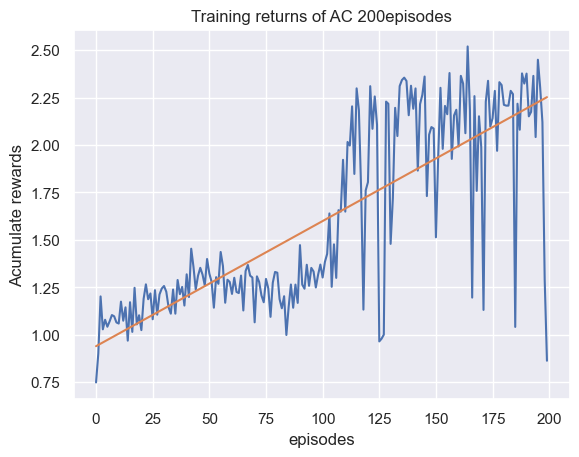

In [36]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

sns.set()

plt.plot(episode_rewards)
plt.ylabel('Acumulate rewards')
plt.xlabel('episodes')
plt.title(f'Training returns of AC {num_episodes}episodes')

reg = LinearRegression().fit(np.arange(len(episode_rewards)).reshape(-1, 1), np.array(episode_rewards).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(episode_rewards)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

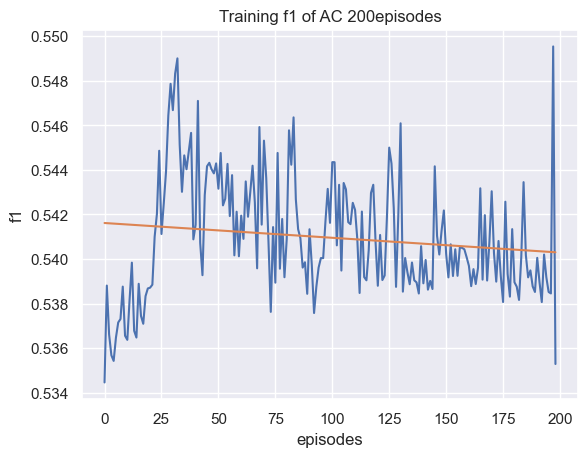

In [37]:


def calculate_averages(numbers):
  """Calculates the average of every 10 consecutive numbers in a list.

  Args:
    numbers: A list of numbers.

  Returns:
    A list of averages, each representing the average of 10 consecutive numbers.
  """

  averages = []
  for i in range(0, len(numbers), 200):
    chunk = numbers[i:i+200]
    average = sum(chunk) / len(chunk)
    averages.append(average)
  return averages

# # Example usage:
# my_list = [1, 2, 3, ..., 200]  # Replace with your actual list of 200 numbers
result = calculate_averages(episode_f1s)
# print(result)



sns.set()

plt.plot(result)
plt.ylabel('f1')
plt.xlabel('episodes')
plt.title(f'Training f1 of AC {num_episodes}episodes')

reg = LinearRegression().fit(np.arange(len(result)).reshape(-1, 1), np.array(result).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(result)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

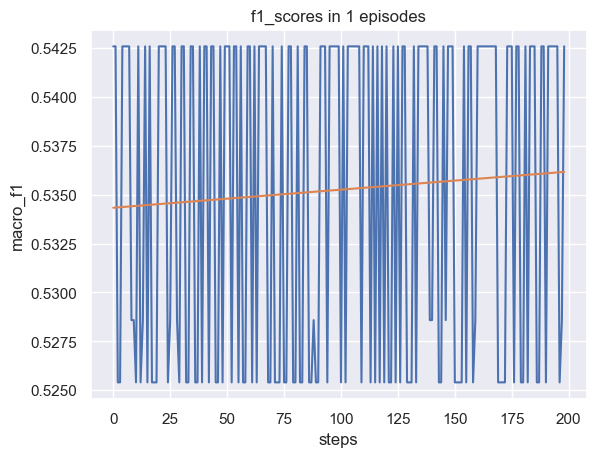

In [38]:
sns.set()

plt.plot(macro_f1_scores)
plt.ylabel('macro_f1')
plt.xlabel('steps')
plt.title(f'f1_scores in 1 episodes')

reg = LinearRegression().fit(np.arange(len(macro_f1_scores)).reshape(-1, 1), np.array(macro_f1_scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(macro_f1_scores)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

In [41]:
#SAVING THE NETWORK.
import os

cwd = os.getcwd()

for i in range(7):
    # Assume `model` is your neural network
    torch.save(actor_critic_networks[i].state_dict(), cwd+f'/AC_data_binary_smote_{i}.pth')

In [42]:
import json
for i in range(7):
    # results.append([episode_rewards, episode_f1s, macro_f1_scores, micro_f1_scores])
    with open(f'data_smote_{i}_episode_f1s.json', 'w') as f:
        json.dump(results[i][1], f)
    with open(f'data_smote_{i}_episode_r.json', 'w') as f:
        json.dump(results[i][0], f)
    with open(f'data_smote_{i}_ma_f1.json', 'w') as f:
        json.dump(results[i][2], f)
    with open(f'data_smote_{i}_mi_f1.json', 'w') as f:
        json.dump(results[i][3], f)

In [45]:
# unique_labels[0]

'Ratsuche'

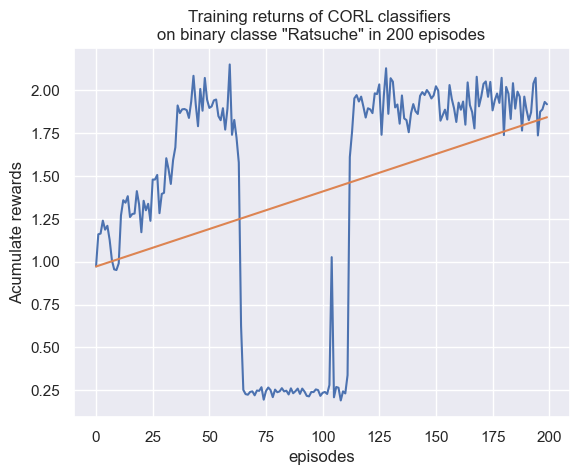

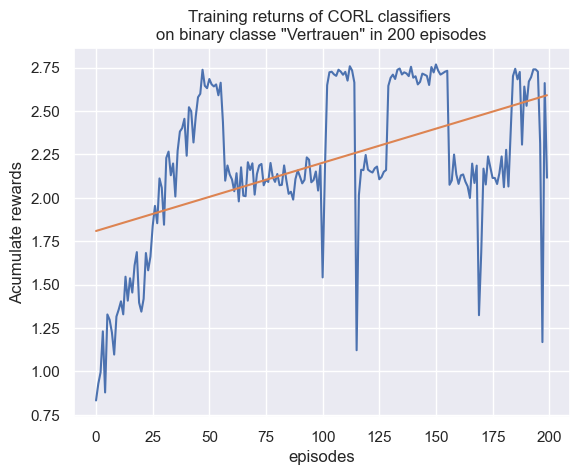

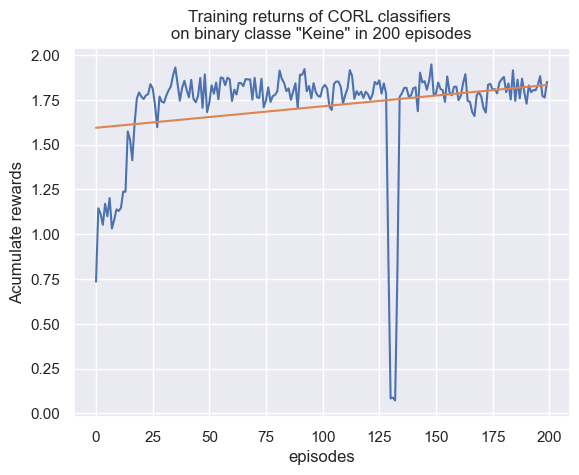

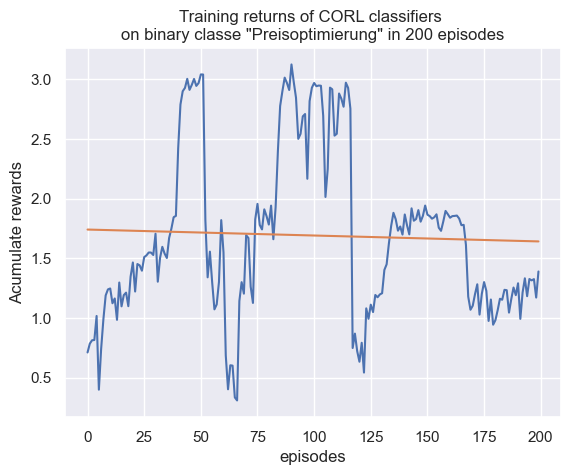

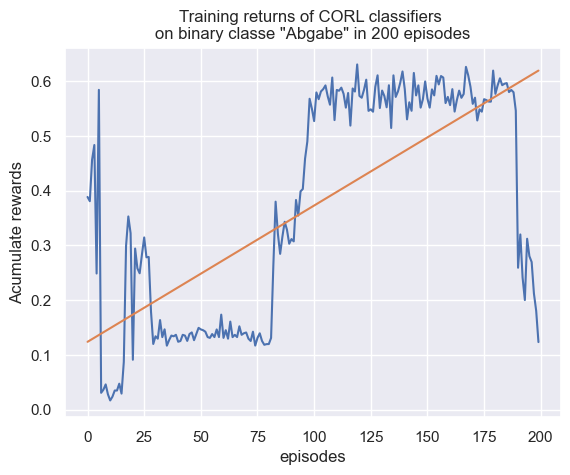

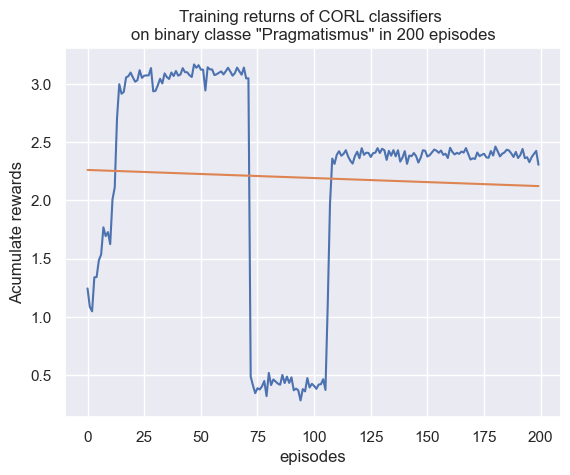

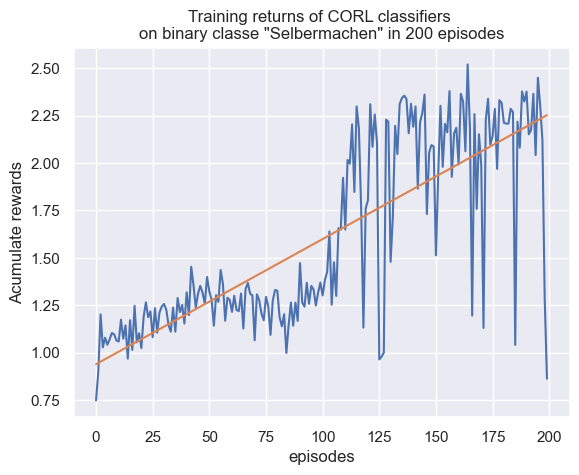

In [47]:

# PLOT THE episode rewards

for i in range(7):
    plot_data = results[i][0]
    plt.plot(plot_data)
    plt.ylabel('Acumulate rewards')
    plt.xlabel('episodes')
    plt.title(f'Training returns of CORL classifiers \non binary classe "{unique_labels[i]}" in {num_episodes} episodes')

    reg = LinearRegression().fit(np.arange(len(plot_data)).reshape(-1, 1), np.array(plot_data).reshape(-1, 1))
    y_pred = reg.predict(np.arange(len(plot_data)).reshape(-1, 1))
    plt.plot(y_pred)
    plt.show()

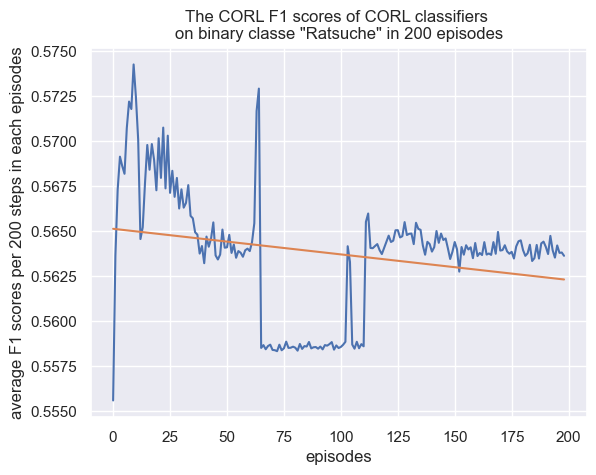

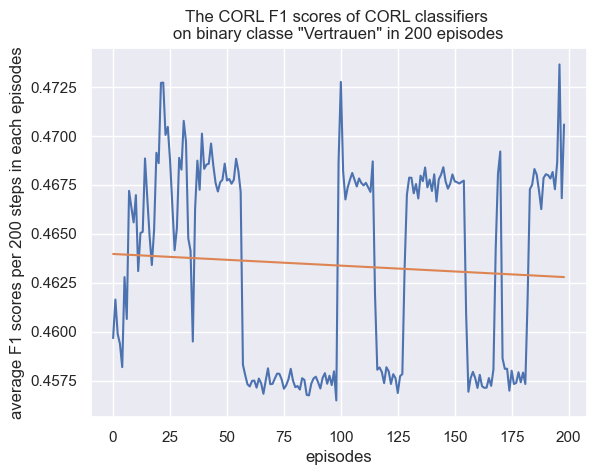

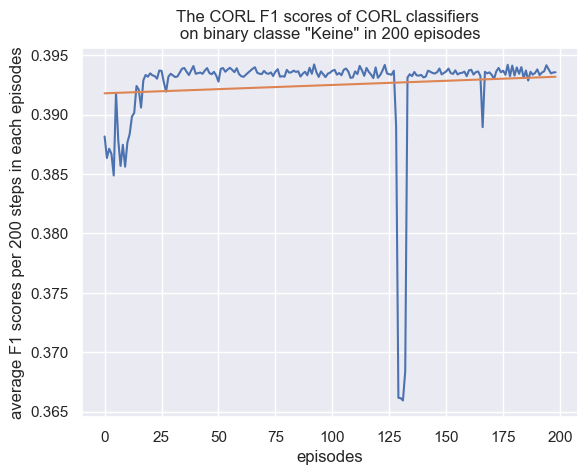

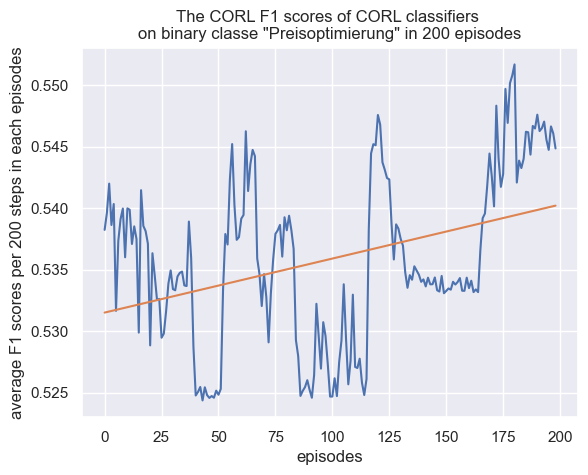

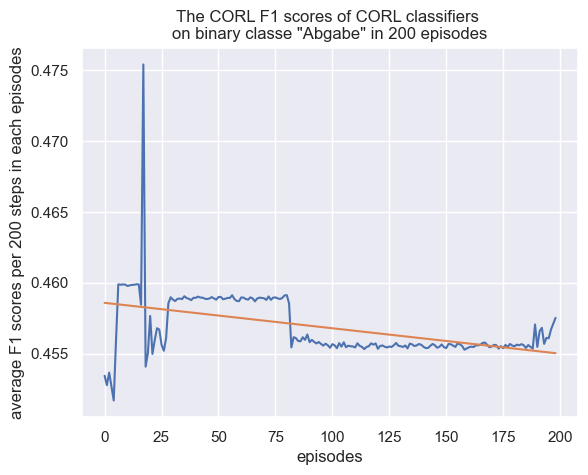

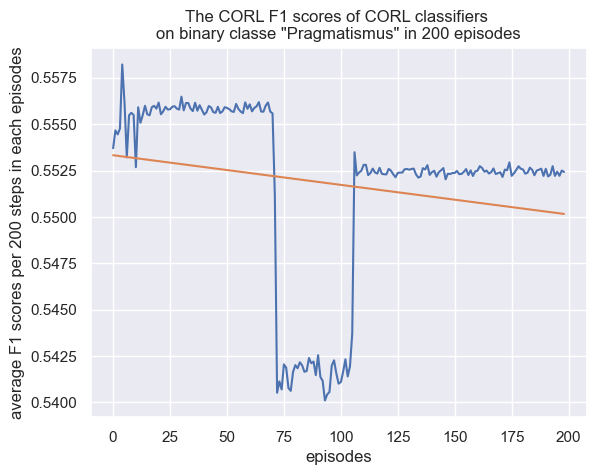

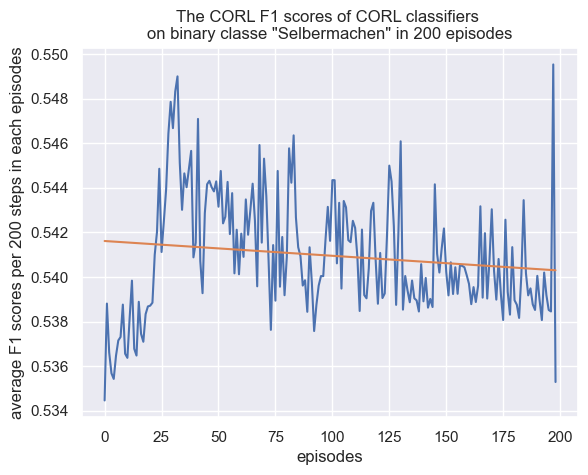

In [48]:
for i in range(7):
    # # Example usage:
    # my_list = [1, 2, 3, ..., 200]  # Replace with your actual list of 200 numbers
    result = results[i][1]
    result = calculate_averages(result)
    # print(result)



    sns.set()

    plt.plot(result)
    plt.ylabel('average F1 scores per 200 steps in each episodes')
    plt.xlabel('episodes')
    plt.title(f'The CORL F1 scores of CORL classifiers \non binary classe "{unique_labels[i]}" in {num_episodes} episodes')

    reg = LinearRegression().fit(np.arange(len(result)).reshape(-1, 1), np.array(result).reshape(-1, 1))
    y_pred = reg.predict(np.arange(len(result)).reshape(-1, 1))
    plt.plot(y_pred)
    plt.show()

In [49]:
for i in range(7):
    # print(envs[i].get_f1())
    

(0.5592371412059334, 0.7884615384615384)
(0.44669531409862906, 0.75)
(0.3944303797468354, 0.5576923076923077)
(0.5515860794579612, 0.8653846153846154)
(0.4583333333333333, 0.8461538461538461)
(0.5358685847220244, 0.7740384615384616)
(0.5425890631872159, 0.7836538461538461)



|macro F1| macro F1|micro F1| micro F1|
|--------|---------|--------|---------|
|0.568|0.559| 0.784| 0.788|
|0.461|0.446| 0.745| 0.750|
|0.387|0.394| 0.543| 0.557|
|0.508|0.551| 0.836| 0.865|
|0.452|0.458| 0.826| 0.846|
|0.564|0.535| 0.778| 0.774|
|0.532|0.542| 0.769| 0.783|
